# Introduction

In [168]:
from scipy.io import arff
import pandas as pd

data, meta = arff.loadarff("synth_multidim_100_000.arff")
data = pd.DataFrame(data)

In [169]:
labels = data['class'].astype(int)
labels[labels != 0] = 1
del data['class']

In [170]:
data['labels'] = labels

In [171]:
data['labels'] = 0
data.loc[data.index.isin([50, 121, 350, 572, 669]),'labels'] = 1

In [172]:
# some matplotlib styling
from matplotlib import rc
import matplotlib.pyplot as plt

rc('text', usetex=True)
plt.style.use('seaborn-notebook')
rc('font',**{'family':'serif','serif':['Cambria']})
plt.rcParams['image.cmap'] = 'Reds'
plt.rcParams['patch.linewidth'] = '0.5'
plt.rcParams['axes.titlesize'] = '18'
plt.rcParams['axes.labelsize'] = '18'
plt.rcParams['legend.fontsize'] = '18'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['ytick.labelsize'] = '12'

<IPython.core.display.Javascript object>


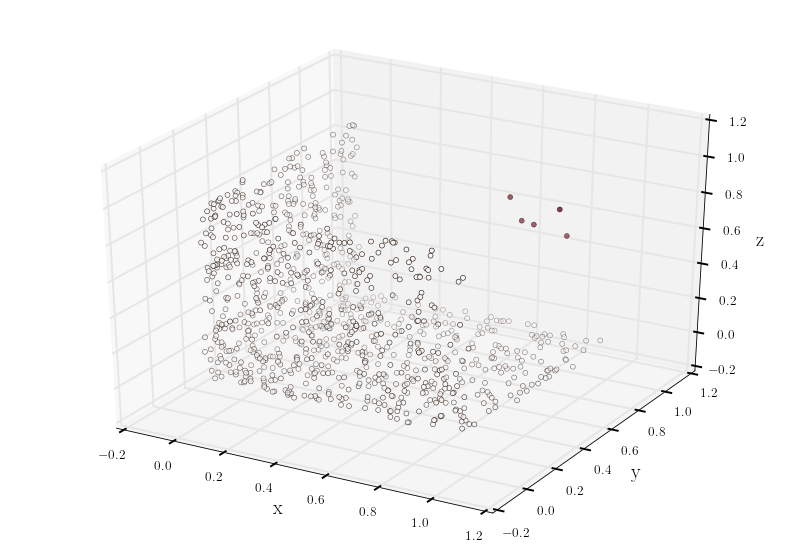

In [174]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure(figsize=(10,7)).gca(projection='3d')
threedee.scatter(data['var_0030'], data['var_0031'], zs=data['var_0032'], 
                 c=data["labels"])
threedee.set_xlabel('x', labelpad=10)
threedee.set_ylabel('y', labelpad=10)
threedee.set_zlabel('z', labelpad=10)
plt.savefig("3d-plot-outlier.svg", format="svg")

<IPython.core.display.Javascript object>


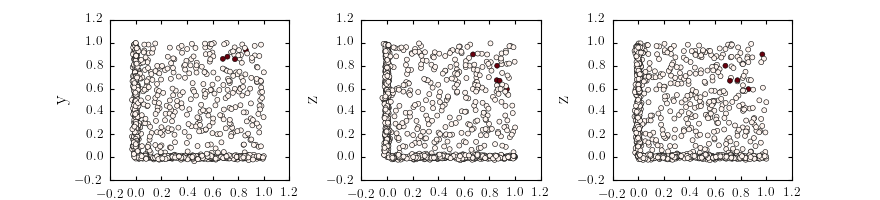

/home/fouchee/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/fouchee/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [167]:
import matplotlib.gridspec as gridspec

# Create 1x3 sub plots
gs = gridspec.GridSpec(1, 3, wspace=0.4)

plt.figure(figsize=(11,2.5))

ax = plt.subplot(gs[0, 0]) # row 0, col 0
plt.scatter(data['var_0030'], data['var_0031'], c=data["labels"])
plt.xlabel('x')
plt.ylabel('y')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.scatter(data['var_0031'], data['var_0032'], c=data["labels"])
plt.xlabel('y')
plt.ylabel('z')

ax = plt.subplot(gs[0, 2]) # row 0, col 3
plt.scatter(data['var_0030'], data['var_0032'], c=data["labels"])
plt.xlabel('x')
plt.ylabel('z')

plt.savefig("2d-plot-outlier.svg", format="svg", bbox_inches='tight')

<IPython.core.display.Javascript object>


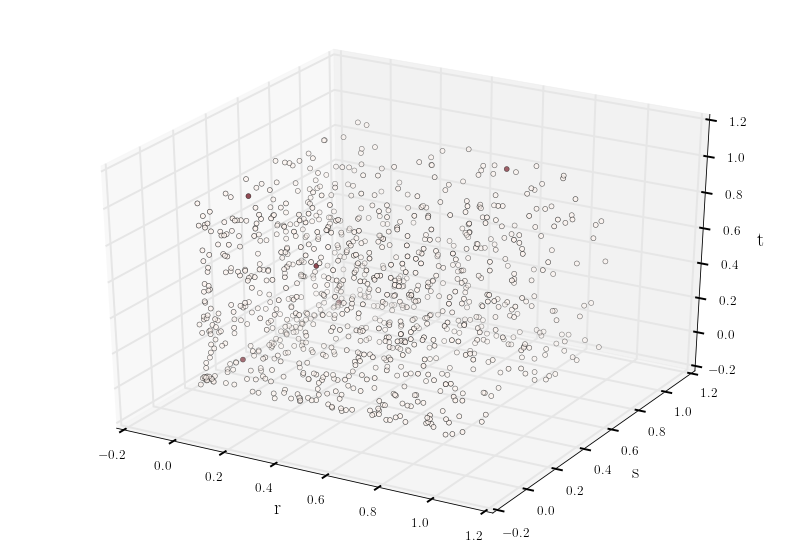

In [175]:
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure(figsize=(10,7)).gca(projection='3d')
threedee.scatter(data['var_0070'], data['var_0080'], zs=data['var_0015'], 
                 c=data["labels"])
threedee.set_xlabel('r', labelpad=10)
threedee.set_ylabel('s', labelpad=10)
threedee.set_zlabel('t', labelpad=10)

plt.savefig("3d-plot-non-outlier.svg", format="svg")

# Autoencoder 

In [107]:
from scipy.io import arff
import pandas as pd

data, meta = arff.loadarff("synth_multidim_100_000.arff")
data = pd.DataFrame(data)

In [108]:
labels = data['class'].astype(int)
labels[labels != 0] = 1
del data['class']

In [57]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data_n = pd.DataFrame(np_scaled)
data_n = data_n.astype('float32')

In [58]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 80  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(100,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(100, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input, output=decoded)

In [59]:
# this model maps an input to its encoded representation
encoder = Model(input=input, output=encoded)

In [60]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [61]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [62]:
# Just compute the distance before learning (show be very bad !)
import numpy as np

encoded = encoder.predict(data_n.values)
decoded = decoder.predict(encoded)
naivedist = np.zeros(len(data_n.values))
for i, x in enumerate(data_n.values):
    naivedist[i] = np.linalg.norm(x-decoded[i])
data['naivedist'] = naivedist

In [63]:
autoencoder.fit(data_n.values, data_n.values,
                nb_epoch=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

# Evaluation

In [64]:
encoded = encoder.predict(data_n.values)
decoded = decoder.predict(encoded)

In [65]:
import numpy as np

dist = np.zeros(len(data_n.values))
for i, x in enumerate(data_n.values):
    dist[i] = np.linalg.norm(x-decoded[i]) # euclidean distance

In [109]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, dist)
roc_auc = auc(fpr, tpr)

<IPython.core.display.Javascript object>


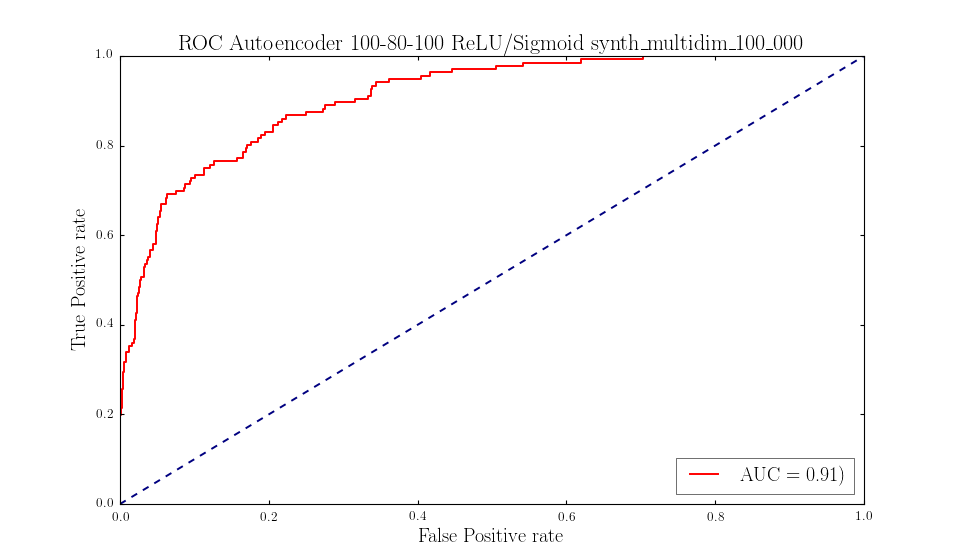

In [112]:
plt.figure(figsize=(12,7))
plt.plot(fpr, tpr, color='red', label='AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Autoencoder 100-80-100 ReLU/Sigmoid synth\_multidim\_100\_000', fontsize=20)
plt.legend(loc="lower right")
plt.show()
plt.savefig("ae-outlier-training-roc.svg", format="svg")

In [135]:
data['labels'] = labels
data['dist'] = dist

<IPython.core.display.Javascript object>


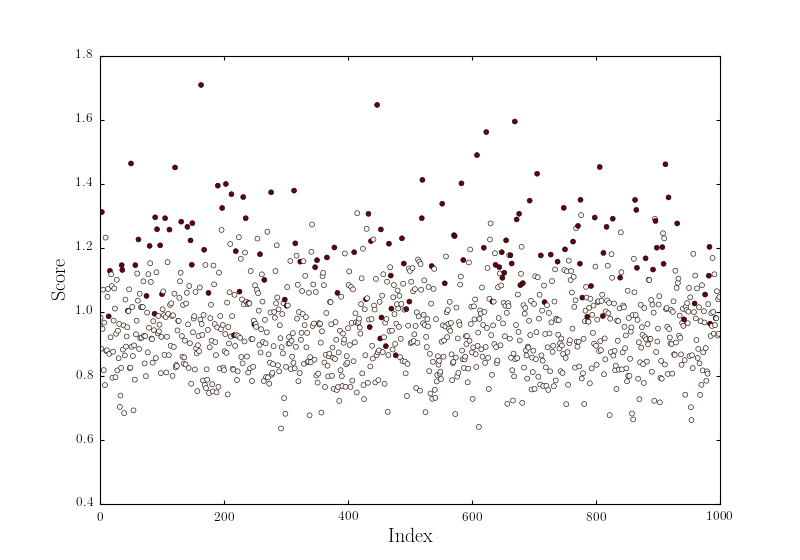

In [115]:
plt.figure(figsize=(10,7))
plt.scatter(data.index, data['dist'], c=data['labels'])
plt.xlabel('Index')
plt.ylabel('Score')
plt.xlim((0,1000))
plt.show()
plt.savefig("ae-outlier-training.svg", format="svg")

<IPython.core.display.Javascript object>


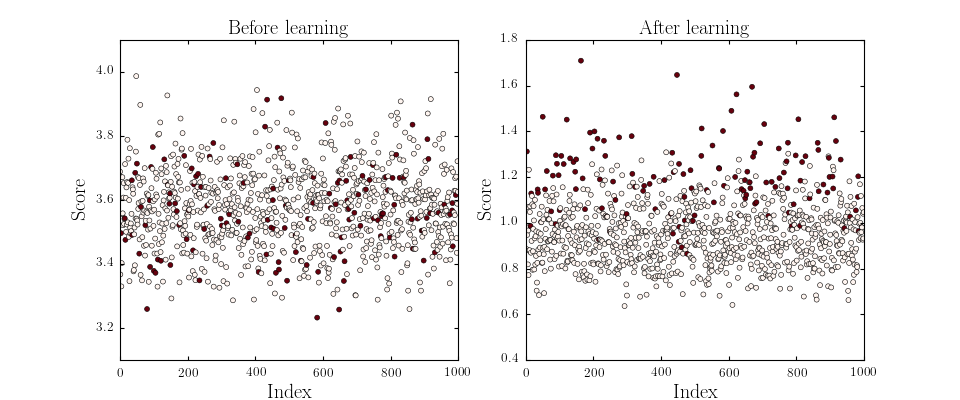

In [137]:
import matplotlib.gridspec as gridspec

# Create 1x2 sub plots
gs = gridspec.GridSpec(1, 2)

plt.figure(figsize=(12,5))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
plt.scatter(data.index, data['naivedist'], c=data["labels"])
plt.xlabel("Index")
plt.ylabel('Score')
plt.xlim((0,1000))
plt.title("Before learning")

ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.scatter(data.index, data['dist'], c=data["labels"])
plt.xlabel('Index')
plt.ylabel('Score')
plt.xlim((0,1000))
plt.title("After learning")
plt.savefig("ae-outlier-training-comp.svg", format="svg")

<IPython.core.display.Javascript object>


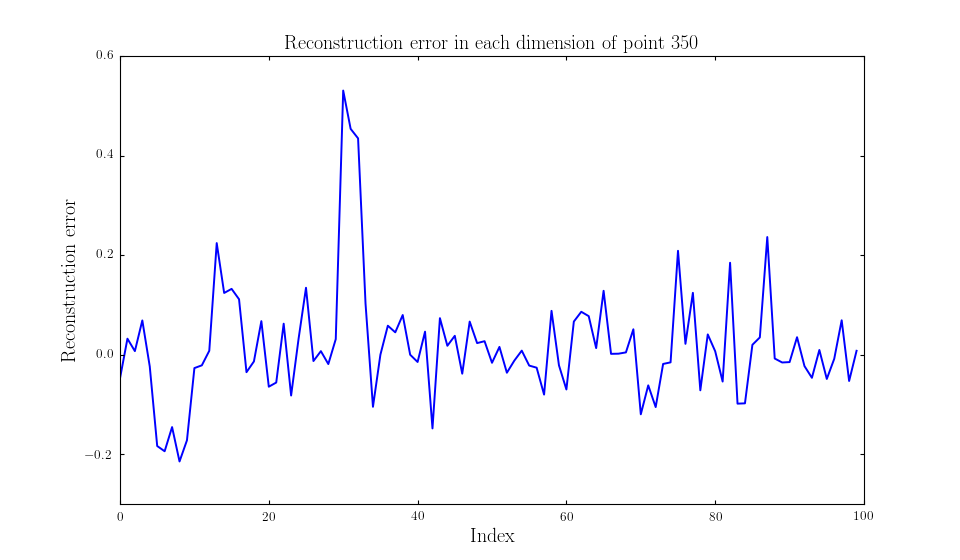

In [122]:
def compute_error_per_dim(point):
    p = np.array(data_n.iloc[point,:]).reshape(1,100)
    encoded = encoder.predict(p)
    decoded = decoder.predict(encoded)
    return np.array(p - decoded)[0]

plt.figure(figsize=(12,7))
plt.plot(compute_error_per_dim(350))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point 350")
plt.savefig("ae-outlier-reconstruction-350.svg", format="svg")

<IPython.core.display.Javascript object>


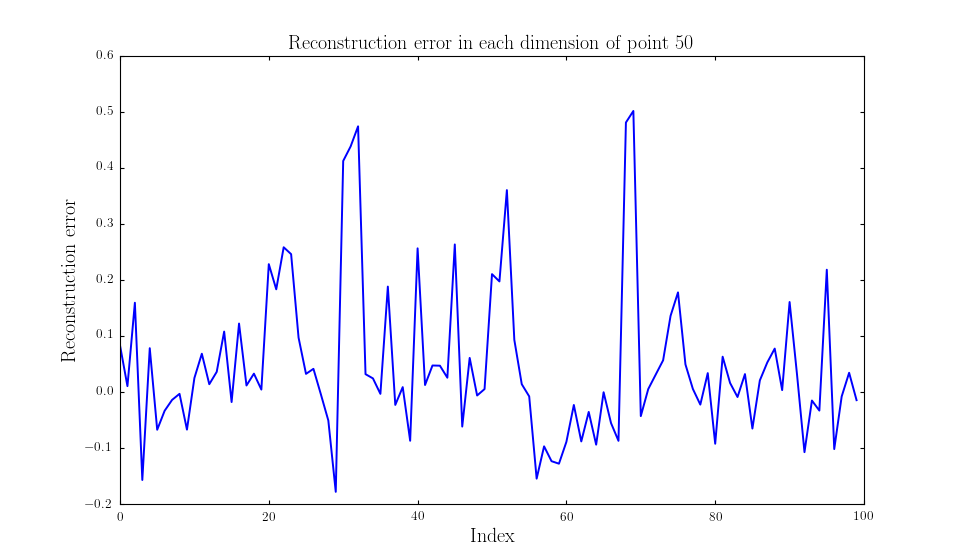

In [123]:
plt.figure(figsize=(12,7))
plt.plot(compute_error_per_dim(50))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point 50")
plt.savefig("ae-outlier-reconstruction-50.svg", format="svg")

In [73]:
# Return a list of the dimensions with the highest reconstruction error
np.argsort(compute_error_per_dim(50))[::-1]

array([69, 68, 32, 31, 30, 52, 45, 22, 40, 23, 20, 95, 50, 51, 36, 21, 75,
       90,  2, 74, 16, 14, 24, 53,  0,  4, 88, 11, 81, 47, 73, 87, 76, 42,
       43, 26, 13, 98, 79, 18, 25, 84, 33, 72, 91, 44, 10, 34, 86, 82, 54,
       12, 41, 17,  1, 38, 77, 49, 71, 19, 89, 65,  8, 35, 27, 48, 55, 97,
       83,  7, 99, 93, 15, 78, 37, 61, 94,  6, 63, 70, 28, 66, 46, 85,  9,
        5, 39, 67, 62, 60, 80, 64, 57, 96, 92, 58, 59, 56,  3, 29])

In [125]:
plt.rcParams.keys()

['agg.path.chunksize',
 'animation.avconv_args',
 'animation.avconv_path',
 'animation.bitrate',
 'animation.codec',
 'animation.convert_args',
 'animation.convert_path',
 'animation.ffmpeg_args',
 'animation.ffmpeg_path',
 'animation.frame_format',
 'animation.html',
 'animation.mencoder_args',
 'animation.mencoder_path',
 'animation.writer',
 'axes.axisbelow',
 'axes.edgecolor',
 'axes.facecolor',
 'axes.formatter.limits',
 'axes.formatter.use_locale',
 'axes.formatter.use_mathtext',
 'axes.formatter.useoffset',
 'axes.grid',
 'axes.grid.axis',
 'axes.grid.which',
 'axes.hold',
 'axes.labelcolor',
 'axes.labelpad',
 'axes.labelsize',
 'axes.labelweight',
 'axes.linewidth',
 'axes.prop_cycle',
 'axes.spines.bottom',
 'axes.spines.left',
 'axes.spines.right',
 'axes.spines.top',
 'axes.titlesize',
 'axes.titleweight',
 'axes.unicode_minus',
 'axes.xmargin',
 'axes.ymargin',
 'axes3d.grid',
 'backend',
 'backend.qt4',
 'backend.qt5',
 'backend_fallback',
 'boxplot.bootstrap',
 'boxplot.

<IPython.core.display.Javascript object>


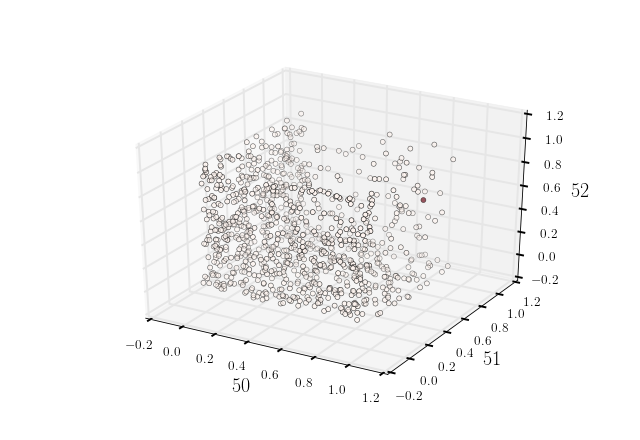

In [127]:
# Look at the position of point 50 in subspace [50,51,52]
data['labels'] = 0
data.loc[data.index.isin([50]),'labels'] = 1

from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.scatter(data['var_0050'], data['var_0051'], zs=data['var_0052'], 
                 c=data["labels"], cmap='Reds')
threedee.set_xlabel('50', labelpad=10)
threedee.set_ylabel('51', labelpad=10)
threedee.set_zlabel('52', labelpad=10)
plt.savefig("3d-plot-non-outlier-50.svg", format="svg")

<IPython.core.display.Javascript object>


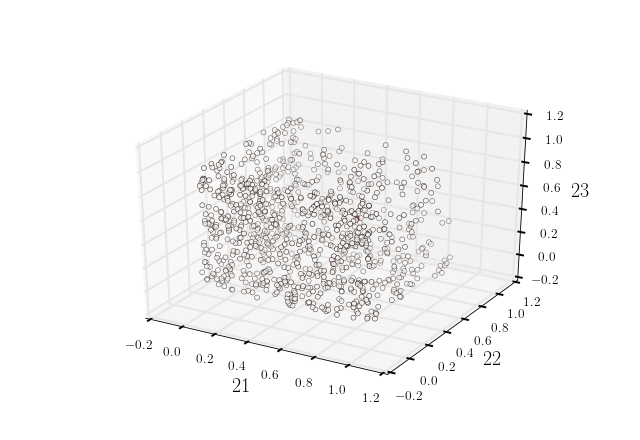

In [128]:
# Look at the position of point 50 in subspace [21,22,23]
data['labels'] = 0
data.loc[data.index.isin([50]),'labels'] = 1

from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.scatter(data['var_0021'], data['var_0022'], zs=data['var_0023'], 
                 c=data["labels"], cmap='Reds')
threedee.set_xlabel('21', labelpad=10)
threedee.set_ylabel('22', labelpad=10)
threedee.set_zlabel('23', labelpad=10)

<IPython.core.display.Javascript object>


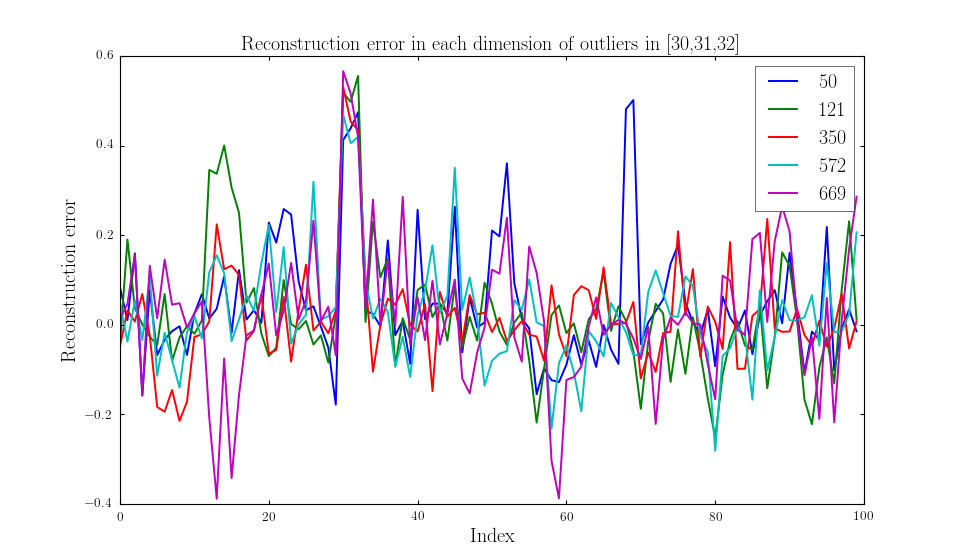

In [129]:
# 50, 121, 350, 572 and 559 are outliers in subspace [30,31,32]
plt.figure(figsize=(12,7))
plt.plot(range(100), compute_error_per_dim(50), label="50")
plt.plot(range(100), compute_error_per_dim(121), label="121")
plt.plot(range(100), compute_error_per_dim(350), label="350")
plt.plot(range(100), compute_error_per_dim(572), label="572")
plt.plot(range(100), compute_error_per_dim(669), label="669")
plt.legend(loc=1)
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of outliers in [30,31,32]")
plt.savefig("ae-outlier-reconstruction-all.svg", format="svg")